### Chatbot with LangGraph

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm= ChatGoogleGenerativeAI(model='gemini-1.0-pro')

input= 'Hi! this is Mani'
llm.invoke(input).content

f:\Generative_AI\Projects\LangGraph-End_to_End\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


"Hello Mani! It's nice to meet you. Is there anything I can help you with today?"

In [6]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage


In [7]:
def call_model(state: MessagesState):
    messages=state['messages']
    response= llm.invoke(messages)
    return {'messages': [response]}

In [8]:
# Building the LangGraph workflow

workflow= StateGraph(MessagesState)
workflow.add_node('chatbot', call_model)
workflow.add_edge(START, 'chatbot')
workflow.add_edge('chatbot', END)
app= workflow.compile()

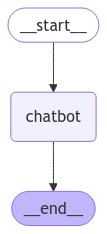

In [9]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# MessagesState is nothing giving input in the form of {'messages':[list of Messages]}
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [10]:
input= {'messages':["Hi, I'm mani"]}
app.invoke(input)

{'messages': [HumanMessage(content="Hi, I'm mani", additional_kwargs={}, response_metadata={}, id='f5d9abde-1831-4751-b597-074feaa97019'),
  AIMessage(content="Hello Mani, it's nice to meet you. My name is Gemini. I am a multi-modal AI model, developed by Google. How can I assist you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-c7afd771-8e1b-4465-b88c-6951ffd045c4-0', usage_metadata={'input_tokens': 7, 'output_tokens': 36, 'total_tokens': 43})]}

In [11]:
for output in app.stream(input):
    for key, value in output.items():
        print(f'output from {key} node')
        print('__________________')
        print(value)
        print('\n')

output from chatbot node
__________________
{'messages': [AIMessage(content="Nice to meet you, Mani. I'm Gemini, a multi-modal AI language model developed by Google. I'm designed to assist and provide information to the best of my abilities. Is there anything I can help you with today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-600bc5c5-9a38-45cb-81db-82b30e048c9b-0', usage_metadata={'input_tokens': 7, 'output_tokens': 49, 'total_tokens': 56})]}




In [12]:
# Creaing the simple tool function
@tool
def search(query: str):
    ''' this is my custom tool function'''
    if 'sf' in query.lower() or 'san francisco' in query.lower():
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."
    
search

StructuredTool(name='search', description='this is my custom tool function', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000025CEDDE79A0>)

In [13]:
search.invoke('what is the temp in sf ?')

"It's 60 degrees and foggy."

In [14]:
# creating tools
tools=[search]

tool_node= ToolNode(tools)

In [18]:
# Binding tools in LLM

llm_with_tool=llm.bind_tools(tools)

def call_model_with_tool(state: MessagesState):
    messages= state['messages']
    response= llm_with_tool.invoke(messages)
    return {'messages': [response]}

input1= {'messages':['Hi, this is mani. how are you?']}
response= call_model_with_tool(input1)
response

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


{'name': 'search', 'description': 'this is my custom tool function', 'parameters': {'type_': 6, 'description': 'this is my custom tool function', 'properties': {'query': {'type_': 1, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}


{'messages': [AIMessage(content='I am doing well. How can I help you today, Mani?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-8aace301-94df-45c0-8195-01be3eadbc74-0', usage_metadata={'input_tokens': 47, 'output_tokens': 14, 'total_tokens': 61})]}

In [ ]:
# Here It gave answer through llm not by tools

messages= response['messages']
last_message= messages[-1]
last_message.tool_calls

[]

In [ ]:
# Here it called the tool based om search query
input2={'messages':['Hi, what is temp in sf ?']}
response= call_model_with_tool(input2)

messages= response['messages']
last_message= messages[-1]
last_message.tool_calls

{'name': 'search', 'description': 'this is my custom tool function', 'parameters': {'type_': 6, 'description': 'this is my custom tool function', 'properties': {'query': {'type_': 1, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}


[{'name': 'search',
  'args': {'query': 'temp in sf'},
  'id': '51d1de17-54a1-4b9d-8ff8-5ca1b8d65187',
  'type': 'tool_call'}]

## DAG - Direct Acyclic graph
- Direct Acyclic graph won't form loop between any functions or node
- Example

In [22]:
# Router function used to identify whether Agent (LLM with tool)  answer itself or calling tool to answer
def router_function(state: MessagesState) -> Literal['tools',END]:
    messages= state['messages']
    last_message= messages[-1]
    if last_message.tool_calls:
        return 'tools'
    else:
        return END

In [23]:
# Making DAG workflow

workflow= StateGraph(MessagesState)

workflow.add_node('agent', call_model_with_tool)
workflow.add_node('tools', tool_node)

workflow.add_edge(START, 'agent')
workflow.add_conditional_edges('agent', router_function, {'tools':'tools', END:END})
app= workflow.compile()

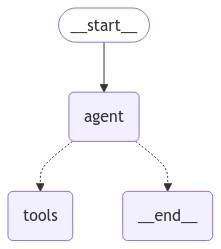

In [25]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [26]:
app.invoke({'messages':['Hi, How are you']})

{'name': 'search', 'description': 'this is my custom tool function', 'parameters': {'type_': 6, 'description': 'this is my custom tool function', 'properties': {'query': {'type_': 1, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}


{'messages': [HumanMessage(content='Hi, How are you', additional_kwargs={}, response_metadata={}, id='30b7f382-2bfa-42e8-ae06-5ad260b7585d'),
  AIMessage(content='I am just a text based chatbot assistant and do not have personal feelings or experiences, therefore I am unable to have a subjective state such as being good or bad. I am here to help you with your language related tasks to the best of my abilities. How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-cbed26dd-4fc2-4af4-8284-561317

In [27]:
app.invoke({"messages": ["what is the weather in sf"]})

{'name': 'search', 'description': 'this is my custom tool function', 'parameters': {'type_': 6, 'description': 'this is my custom tool function', 'properties': {'query': {'type_': 1, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}


{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='4315508d-2a37-4194-8e49-5162ae2cb282'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "What is the weather in San Francisco"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-923d5462-5853-444f-ad61-306187ee4bc0-0', tool_calls=[{'name': 'search', 'args': {'query': 'What is the weather in San Francisco'}, 'id': '97f3614a-41c7-4d06-bbdd-5a29ebd7024a', 'type': 'tool_call

## DCE - Direct Cyclic Graph Generation

- In DCE, we can find a cyclic pattern. its forming a loop between functions or nodes
- Example

In [28]:
def router_function(state: MessagesState) -> Literal['tools',END]:
    messages= state['messages']
    last_message= messages[-1]
    if last_message.tool_calls:
        return 'tools'
    else:
        return END

In [29]:
# Making DCE workflow

workflow= StateGraph(MessagesState)

workflow.add_node('agent', call_model_with_tool)
workflow.add_node('tools', tool_node)

workflow.add_edge(START, 'agent')
workflow.add_conditional_edges('agent', router_function, {'tools':'tools', END:END})
# looping the tools node with agent node
workflow.add_edge('tools', 'agent')
apps= workflow.compile()

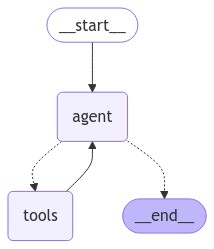

In [30]:
from IPython.display import display, Image
display(Image(apps.get_graph().draw_mermaid_png()))

In [31]:
apps.invoke({'messages':['what is weather in sf ?']})

{'name': 'search', 'description': 'this is my custom tool function', 'parameters': {'type_': 6, 'description': 'this is my custom tool function', 'properties': {'query': {'type_': 1, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'search', 'description': 'this is my custom tool function', 'parameters': {'type_': 6, 'description': 'this is my custom tool function', 'properties': {'query': {'type_': 1, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}


{'messages': [HumanMessage(content='what is weather in sf ?', additional_kwargs={}, response_metadata={}, id='002f097c-acf7-49bc-912d-9db0f43c1d8d'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in sf"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-101119e0-0e38-4486-b94c-476d76308844-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'f4277a56-9f6e-4cf4-9971-1f519877555a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 43, 'output

In [32]:
for output in apps.stream({'messages':['what is weather in sf ?']}):
    for key, value in output.items():
        print(f'output from {key} node')
        print('________________')
        print(value)
        print('\n')

{'name': 'search', 'description': 'this is my custom tool function', 'parameters': {'type_': 6, 'description': 'this is my custom tool function', 'properties': {'query': {'type_': 1, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
output from agent node
________________
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "What is weather in sf ?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocke

## LangGraph bot with memory (chat history)


In [44]:
from langgraph.checkpoint.memory import MemorySaver

memory= MemorySaver()

In [45]:
# DCE- Direct cyclic graph

workflow= StateGraph(MessagesState)
workflow.add_node('agent', call_model_with_tool)
workflow.add_node('tools', tool_node)
workflow.add_edge(START, 'agent')
workflow.add_conditional_edges('agent', router_function, {'tools':'tools', END:END})
workflow.add_edge('tools','agent')
app2= workflow.compile(checkpointer=memory)

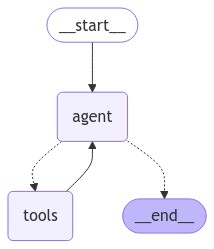

In [46]:
from IPython.display import display, Image

try:
    display(Image(app2.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [47]:
## Adding memory config thred to save chat history
config = {"configurable": {"thread_id": "1"}}


events= app2.stream({'messages':["Hi there! My name is Mani"]}, config, stream_mode='values')
for event in events:    
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Mani
{'name': 'search', 'description': 'this is my custom tool function', 'parameters': {'type_': 6, 'description': 'this is my custom tool function', 'properties': {'query': {'type_': 1, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
================================== Ai Message ==================================

Hello Mani, how can I help you today?


In [48]:
events= app2.stream({'messages':["can you tell me what was my name?"]}, config, stream_mode='values')
for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

can you tell me what was my name?
{'name': 'search', 'description': 'this is my custom tool function', 'parameters': {'type_': 6, 'description': 'this is my custom tool function', 'properties': {'query': {'type_': 1, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
================================== Ai Message ==================================

I am sorry, I cannot fulfill this request. I do not have the functionality to access your name.


In [49]:
memory.get(config)

{'v': 1,
 'ts': '2024-11-23T11:14:00.397204+00:00',
 'id': '1efa98c0-a3ba-67d0-8004-b93e714ac4fd',
 'channel_values': {'messages': [HumanMessage(content='Hi there! My name is Mani', additional_kwargs={}, response_metadata={}, id='09c1e5a1-ab36-48de-8e0b-ee8e728d25ae'),
   AIMessage(content='Hello Mani, how can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-2672dbfa-84af-45b4-b129-63cb935709ad-0', usage_metadata={'input_tokens': 44, 'output_tokens': 10, 'total_tokens': 54}),
   HumanMessage(cont